[*********************100%%**********************]  1 of 1 completed



📈 **Final Trading Summary**
✅ Best MACD Parameters Found: Short EMA = 8, Long EMA = 20, Signal = 7
🔹 Total Trades Executed: 53
🔹 Total Profit from Trading: $-35.25
🔹 Total Transaction Costs: $54.00

📊 **Comparison of MACD Trading vs. Buy & Hold**
🔹 MACD Strategy Final Value: $99,937.75
🔹 Buy & Hold Final Value: $99,784.29
✅ **MACD Trading Outperformed the Market!**

Trade Log:
🚀 BUY 3 @ 6140.00 on 2025-02-14 00:45:00-05:00 | Fee: $1.00
🚨 STOP LOSS LONG 3 @ 6139.25 on 2025-02-14 00:47:00-05:00 | Profit: $-3.25 | Fee: $1.00
🚀 SHORT SELL 3 @ 6139.25 on 2025-02-14 00:47:00-05:00 | Fee: $1.00
🚨 STOP LOSS SHORT 3 @ 6140.00 on 2025-02-14 00:52:00-05:00 | Profit: $-3.25 | Fee: $1.00
🚀 SHORT SELL 3 @ 6140.50 on 2025-02-14 01:20:00-05:00 | Fee: $1.00
🚨 STOP LOSS SHORT 3 @ 6141.00 on 2025-02-14 01:44:00-05:00 | Profit: $-2.50 | Fee: $1.00
🚀 SHORT SELL 3 @ 6140.25 on 2025-02-14 01:51:00-05:00 | Fee: $1.00
🚨 STOP LOSS SHORT 3 @ 6140.75 on 2025-02-14 01:53:00-05:00 | Profit: $-2.50 | Fee: $1.00
🚀 B

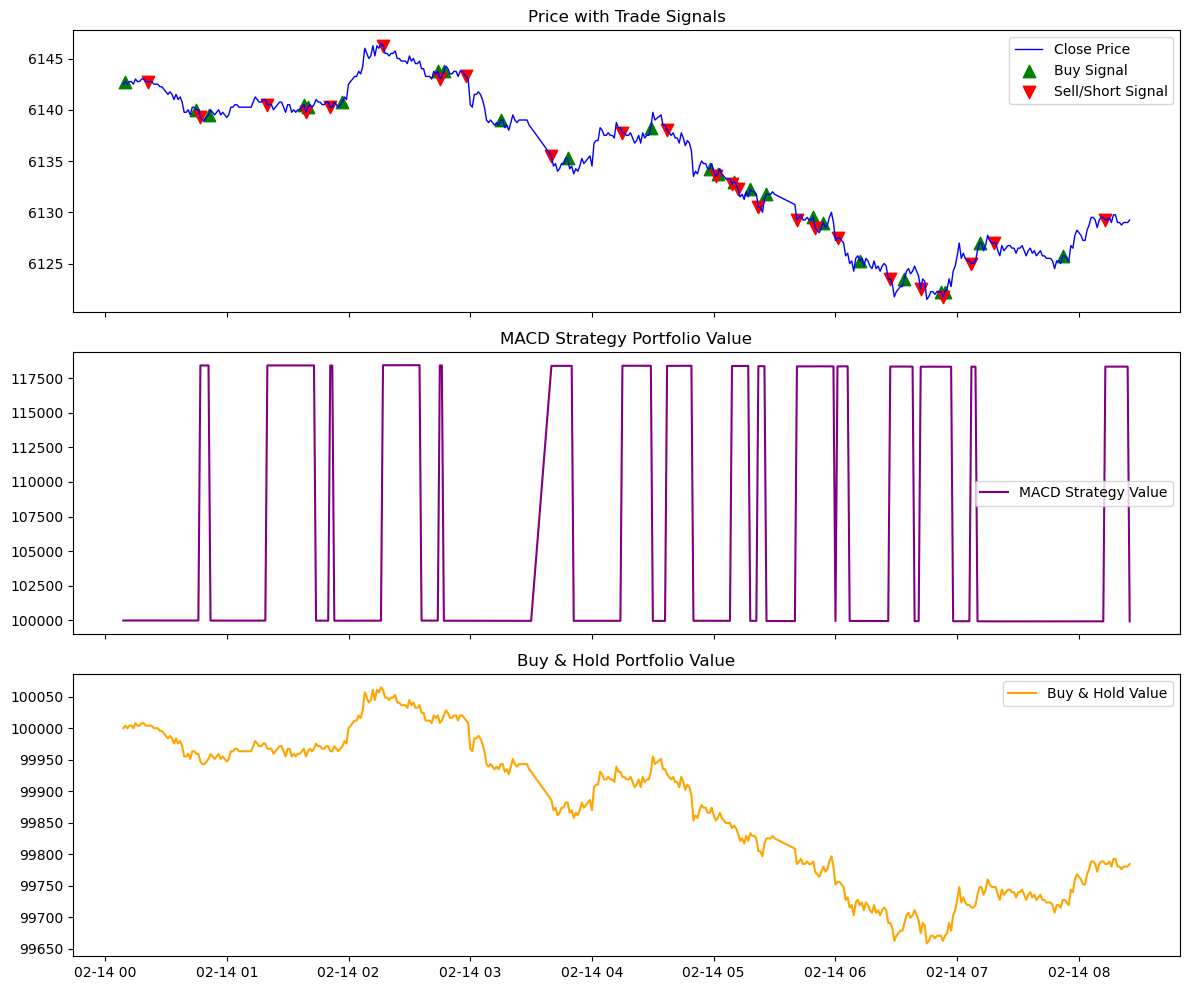

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from itertools import product

# 1) Download real-time 1-minute data
ticker = "ES=F"  # S&P 500 E-mini Futures
df = yf.download(ticker, period="1d", interval="1m")

# Ensure proper indexing
df = df.reset_index()
df.rename(columns={"Datetime": "Date"}, inplace=True)
df.set_index("Date", inplace=True)

# --- Compute ATR for dynamic stops ---
# ATR calculation using a 14-period window
df['H-L'] = df['High'] - df['Low']
df['H-PC'] = (df['High'] - df['Close'].shift(1)).abs()
df['L-PC'] = (df['Low'] - df['Close'].shift(1)).abs()
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()
# -------------------------------------------------

# 2) Parameter grid search for best MACD settings
short_ema_range = [3, 5, 8]
long_ema_range = [10, 15, 20]
signal_range = [3, 5, 7]

best_profit = -np.inf
best_params = None

# For the grid search, we use a simple backtest considering only long trades.
for short_ema, long_ema, signal in product(short_ema_range, long_ema_range, signal_range):
    if short_ema >= long_ema:
        continue

    # Calculate MACD and Signal Line for current parameters
    df["MACD"] = df["Close"].ewm(span=short_ema, adjust=False).mean() - df["Close"].ewm(span=long_ema, adjust=False).mean()
    df["Signal_Line"] = df["MACD"].ewm(span=signal, adjust=False).mean()
    
    # Generate trade signals
    df["Position"] = 0
    df.loc[df["MACD"] > df["Signal_Line"], "Position"] = 1
    df.loc[df["MACD"] < df["Signal_Line"], "Position"] = -1
    df["Trade_Signal"] = df["Position"].diff().replace({2: 1, -2: -1})
    
    # Simple backtest logic (only long trades)
    initial_cash = 100000
    cash = initial_cash
    shares = 0
    total_profit = 0
    transaction_cost = 1.00
    entry_price = 0

    for i in range(len(df)):
        price = df["Close"].iloc[i]
        
        if df["Trade_Signal"].iloc[i] == 1:  # Buy signal
            shares = int(cash / (price * 10))
            if shares > 0 and cash >= shares * price + transaction_cost:
                cash -= shares * price + transaction_cost
                entry_price = price

        elif df["Trade_Signal"].iloc[i] == -1 and shares > 0:  # Sell signal
            trade_profit = (price - entry_price) * shares - transaction_cost
            if trade_profit >= 0:  # Sell only if not at a loss
                cash += shares * price - transaction_cost
                total_profit += trade_profit
                shares = 0

    if total_profit > best_profit:
        best_profit = total_profit
        best_params = (short_ema, long_ema, signal)

# 3) Apply best MACD settings
best_short_ema, best_long_ema, best_signal = best_params
df["MACD_Best"] = df["Close"].ewm(span=best_short_ema, adjust=False).mean() - df["Close"].ewm(span=best_long_ema, adjust=False).mean()
df["Signal_Best"] = df["MACD_Best"].ewm(span=best_signal, adjust=False).mean()

df["Position"] = 0
df.loc[df["MACD_Best"] > df["Signal_Best"], "Position"] = 1
df.loc[df["MACD_Best"] < df["Signal_Best"], "Position"] = -1
df["Trade_Signal"] = df["Position"].diff().replace({2: 1, -2: -1})

# 4) Final Trading Execution with Short Selling, Dynamic Stops, and Final Close-Out

initial_cash = 100000
cash = initial_cash
position = 0         # positive for long, negative for short
entry_price = None   # Price at which the current position was opened
entry_atr = None     # ATR value at the time of entry (for dynamic stops)
total_transaction_costs = 0
trade_log = []
total_trades = 0
total_profit = 0
portfolio_value = []

transaction_cost = 1.00

# New trade sizing: use 20% of available cash
def calculate_trade_size(price, cash_available):
    max_trade_size = 500  # Limit per trade
    return min(max_trade_size, int((cash_available * 0.2) / price))

# Define dynamic stop multipliers (in ATR multiples)
stop_loss_multiplier = 1.0
take_profit_multiplier = 2.0

for i in range(len(df)):
    price = df["Close"].iloc[i]
    signal = df["Trade_Signal"].iloc[i]
    
    # Skip if ATR is not available yet (NaN)
    current_atr = df["ATR"].iloc[i]
    if np.isnan(current_atr):
        portfolio_value.append(cash if position == 0 else (cash + position * price))
        continue

    # === Check for Dynamic Stop-Loss / Take-Profit conditions on open positions ===
    if position > 0:  # Long position
        stop_loss_long = entry_price - stop_loss_multiplier * entry_atr
        take_profit_long = entry_price + take_profit_multiplier * entry_atr
        if price >= take_profit_long:
            # Take profit for long position
            trade_profit = (price - entry_price) * position - transaction_cost
            cash += position * price - transaction_cost
            total_profit += trade_profit
            total_transaction_costs += transaction_cost
            trade_log.append(f"💰 TAKE PROFIT LONG {position} @ {price:.2f} on {df.index[i]} | Profit: ${trade_profit:.2f} | Fee: ${transaction_cost:.2f}")
            total_trades += 1
            position = 0
            entry_price = None
            entry_atr = None
        elif price <= stop_loss_long:
            # Stop loss for long position
            trade_profit = (price - entry_price) * position - transaction_cost
            cash += position * price - transaction_cost
            total_profit += trade_profit
            total_transaction_costs += transaction_cost
            trade_log.append(f"🚨 STOP LOSS LONG {position} @ {price:.2f} on {df.index[i]} | Profit: ${trade_profit:.2f} | Fee: ${transaction_cost:.2f}")
            total_trades += 1
            position = 0
            entry_price = None
            entry_atr = None

    elif position < 0:  # Short position
        stop_loss_short = entry_price + stop_loss_multiplier * entry_atr
        take_profit_short = entry_price - take_profit_multiplier * entry_atr
        if price <= take_profit_short:
            # Take profit for short position
            trade_profit = (entry_price - price) * abs(position) - transaction_cost
            cash -= price * abs(position) + transaction_cost
            total_profit += trade_profit
            total_transaction_costs += transaction_cost
            trade_log.append(f"💰 TAKE PROFIT SHORT {abs(position)} @ {price:.2f} on {df.index[i]} | Profit: ${trade_profit:.2f} | Fee: ${transaction_cost:.2f}")
            total_trades += 1
            position = 0
            entry_price = None
            entry_atr = None
        elif price >= stop_loss_short:
            # Stop loss for short position
            trade_profit = (entry_price - price) * abs(position) - transaction_cost
            cash -= price * abs(position) + transaction_cost
            total_profit += trade_profit
            total_transaction_costs += transaction_cost
            trade_log.append(f"🚨 STOP LOSS SHORT {abs(position)} @ {price:.2f} on {df.index[i]} | Profit: ${trade_profit:.2f} | Fee: ${transaction_cost:.2f}")
            total_trades += 1
            position = 0
            entry_price = None
            entry_atr = None

    # === Process new signals if no open position exists or after an exit ===
    if signal == 1:
        # If currently short, cover the short position first (if profitable)
        if position < 0:
            trade_profit = (entry_price - price) * abs(position) - transaction_cost
            if trade_profit >= 0:
                cash -= price * abs(position) + transaction_cost
                total_profit += trade_profit
                total_transaction_costs += transaction_cost
                trade_log.append(f"📈 COVER SHORT {abs(position)} @ {price:.2f} on {df.index[i]} | Profit: ${trade_profit:.2f} | Fee: ${transaction_cost:.2f}")
                total_trades += 1
                position = 0
                entry_price = None
                entry_atr = None
        # If no open position, open a long position
        if position == 0:
            shares = calculate_trade_size(price, cash)
            if shares > 0 and cash >= shares * price + transaction_cost:
                cash -= shares * price + transaction_cost
                total_transaction_costs += transaction_cost
                entry_price = price
                entry_atr = current_atr  # record ATR at entry time
                position = shares  # long position
                trade_log.append(f"🚀 BUY {shares} @ {price:.2f} on {df.index[i]} | Fee: ${transaction_cost:.2f}")
                total_trades += 1

    elif signal == -1:
        # If currently long, sell to close the long position first (if profitable)
        if position > 0:
            trade_profit = (price - entry_price) * position - transaction_cost
            if trade_profit >= 0:
                cash += position * price - transaction_cost
                total_profit += trade_profit
                total_transaction_costs += transaction_cost
                trade_log.append(f"📉 SELL {position} @ {price:.2f} on {df.index[i]} | Profit: ${trade_profit:.2f} | Fee: ${transaction_cost:.2f}")
                total_trades += 1
                position = 0
                entry_price = None
                entry_atr = None
        # If no open position, open a short position
        if position == 0:
            shares = calculate_trade_size(price, cash)
            if shares > 0:
                cash += shares * price - transaction_cost
                total_transaction_costs += transaction_cost
                entry_price = price
                entry_atr = current_atr  # record ATR at entry time
                position = -shares  # short position (negative)
                trade_log.append(f"🚀 SHORT SELL {shares} @ {price:.2f} on {df.index[i]} | Fee: ${transaction_cost:.2f}")
                total_trades += 1

    # Update portfolio value
    if position > 0:
        portfolio_value.append(cash + position * price)
    elif position < 0:
        portfolio_value.append(cash + (entry_price - price) * abs(position))
    else:
        portfolio_value.append(cash)

# --- Final Closing of Open Positions ---
final_price = df["Close"].iloc[-1]

if position > 0:  # Long position open
    trade_profit = (final_price - entry_price) * position - transaction_cost
    cash += position * final_price - transaction_cost
    total_profit += trade_profit
    total_transaction_costs += transaction_cost
    trade_log.append(f"📊 FINAL SELL {position} @ {final_price:.2f} on {df.index[-1]} | Profit: ${trade_profit:.2f} | Fee: ${transaction_cost:.2f}")
    position = 0
elif position < 0:  # Short position open
    trade_profit = (entry_price - final_price) * abs(position) - transaction_cost
    cash -= final_price * abs(position) + transaction_cost
    total_profit += trade_profit
    total_transaction_costs += transaction_cost
    trade_log.append(f"📊 FINAL COVER SHORT {abs(position)} @ {final_price:.2f} on {df.index[-1]} | Profit: ${trade_profit:.2f} | Fee: ${transaction_cost:.2f}")
    position = 0

# Update final portfolio value
portfolio_value[-1] = cash

# Align portfolio value with the DataFrame length
df = df.iloc[:len(portfolio_value)]
df["MACD_Strategy_Value"] = portfolio_value

# Create a Buy & Hold benchmark
df["Buy_Hold_Value"] = initial_cash * (df["Close"] / df["Close"].iloc[0])

# 5) Print Final Results
print("\n" + "="*60)
print("📈 **Final Trading Summary**")
print("="*60)
print(f"✅ Best MACD Parameters Found: Short EMA = {best_short_ema}, Long EMA = {best_long_ema}, Signal = {best_signal}")
print(f"🔹 Total Trades Executed: {total_trades}")
print(f"🔹 Total Profit from Trading: ${total_profit:,.2f}")
print(f"🔹 Total Transaction Costs: ${total_transaction_costs:,.2f}")

print("\n📊 **Comparison of MACD Trading vs. Buy & Hold**")
print(f"🔹 MACD Strategy Final Value: ${df['MACD_Strategy_Value'].iloc[-1]:,.2f}")
print(f"🔹 Buy & Hold Final Value: ${df['Buy_Hold_Value'].iloc[-1]:,.2f}")

if df['MACD_Strategy_Value'].iloc[-1] > df['Buy_Hold_Value'].iloc[-1]:
    print("✅ **MACD Trading Outperformed the Market!**")
else:
    print("❌ **MACD Trading Underperformed the Market!**")
print("="*60)

print("\nTrade Log:")
for trade in trade_log:
    print(trade)

# 6) Visualize the Results
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Subplot 1: Price with Trade Signals
axs[0].plot(df.index, df["Close"], label="Close Price", color='blue', linewidth=1)
buy_signals = df[df["Trade_Signal"] == 1]
sell_signals = df[df["Trade_Signal"] == -1]
axs[0].scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", label="Buy Signal", s=80)
axs[0].scatter(sell_signals.index, sell_signals["Close"], marker="v", color="red", label="Sell/Short Signal", s=80)
axs[0].set_title("Price with Trade Signals")
axs[0].legend()

# Subplot 2: MACD Strategy Portfolio Value
axs[1].plot(df.index, df["MACD_Strategy_Value"], label="MACD Strategy Value", color="purple")
axs[1].set_title("MACD Strategy Portfolio Value")
axs[1].legend()

# Subplot 3: Buy & Hold Value
axs[2].plot(df.index, df["Buy_Hold_Value"], label="Buy & Hold Value", color="orange")
axs[2].set_title("Buy & Hold Portfolio Value")
axs[2].legend()

plt.tight_layout()
plt.show()
